# Augmented Reality with Planar Homographies

In [161]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from utils import read_video, play_video
from tqdm import tqdm

In [162]:
def get_correspondences(img, video, ratio=0.3):
    """
    Get the corresponding points from the image and the video
    params:
        img: the image
        video: list of frames from the video or a single frame
    returns:
        src_pts: the points from the image
        dst_pts: the points from the video
    """
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img, None)

    kp2 = []
    des2 = []
    
    # check if the video is a list of frames or a single frame
    if type(video) == list:
        for frame in video:
            kp, des = sift.detectAndCompute(frame, None)
            kp2.append(kp)
            des2.append(des)
    else:
        kp, des = sift.detectAndCompute(video, None)
        kp2.append(kp)
        des2.append(des)

    bf = cv.BFMatcher()
    matches = []
    for des in des2:
        matches.append(bf.knnMatch(des1, des, k=2))
    
    # Apply ratio test for each frame
    good = []
    for match in matches:
        good.append([])
        for m, n in match:
            if m.distance < ratio * n.distance:
                good[-1].append(m)
    
    # sort the matches based on the distance
    for i in range(len(good)):
        good[i] = sorted(good[i], key = lambda x:x.distance)
    
    src_pts = []
    dst_pts = []
    for i in range(len(good)):
        src_pts.append(np.float32([kp1[m.queryIdx].pt for m in good[i]]).reshape(-1, 1, 2))
        dst_pts.append(np.float32([kp2[i][m.trainIdx].pt for m in good[i]]).reshape(-1, 1, 2))
    
    # plot the matches for every frame
    matching_frames = []
    for i in range(len(good)):
        img3 = cv.drawMatches(img, kp1, video[i], kp2[i], good[i], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        matching_frames.append(img3)

    return src_pts, dst_pts, matching_frames

In [163]:
# built in function to find the homography
def get_homography_built_in(img_pts, video_pts):
    """
    This function takes in the corresponding points and returns the homography matrix
    params:
        img_pts: corresponding points in the image
        video_pts: corresponding points in the video
    returns:
        H: homography matrix
    """
    # get homography matrix
    H, _ = cv.findHomography(np.array(img_pts), np.array(video_pts), cv.RANSAC, 5.0)
    return H

In [164]:
# implement the homography matrix from scratch
def get_homography_implementation(img_pts, video_pts):
    """
    This function takes in the corresponding points in the image and the video and returns the homography matrix
    params:
        img_pts: corresponding points in the image
        video_pts: corresponding points in the video
    returns:
        H: homography matrix
    """
    # get the homography matrix
    A = []
    b = []
    for i in range(len(img_pts)):
        x, y = img_pts[i].squeeze()
        u, v = video_pts[i].squeeze()
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y])
        b.append(u)
        b.append(v)
    A = np.array(A)
    b = np.array(b)
    H = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.append(H, 1).reshape(3, 3)
    return H

In [165]:
# transforming perspective of a set of points using homography
def transformPerspectivePts(pts, M):
    """
    This function transforms a list of points using a given homography matrix
    params:
        pts: the coordinates of source points
        M: homography matrix used for transformation
    returns:
        pts_transformed: the coordinates of the destination points
    """
    pts_transformed = []
    for pt in pts:
        p = np.array([pt[0][0], pt[0][1], 1])
        p_dash = np.dot(M, p)
        x_dash, y_dash = (p_dash[0]/p_dash[2]), (p_dash[1]/p_dash[2])
        pts_transformed.append([[x_dash, y_dash]])
    
    return pts_transformed

In [179]:
# transforming perspective of an image using homography
def transformPerspectiveImage(img_src, M, dst_shape):
    """
    This function warps an image using a given homography matrix
    params:
        img_src: the image to be warped
        M: homography matrix used for transformation
        dst_shape: the dimensions of the destination frame
    returns:
        warped_image: the resulting image from the transformation
    """
    dst_shapeX, dst_shapeY = dst_shape
    warped_image = np.zeros((dst_shapeY, dst_shapeX, 3), dtype='uint8')
    
    for y in range(img_src.shape[0]):
        for x in range(img_src.shape[1]):
            p = np.array([x,y,1])
            p_dash = np.dot(M, p)
            x_dash, y_dash = (p_dash[0]/p_dash[2]), (p_dash[1]/p_dash[2])

            if 0 < y_dash+1 < warped_image.shape[0] and 0 < x_dash+1 < warped_image.shape[1]:
                warped_image[int(y_dash), int(x_dash), :] = img_src[y, x, :]
    
    return warped_image

In [167]:
def video_crop_pad(video, shape: tuple):
    """
    This function crops and pade the video to the given shape
    params:
        video: list of frames from the video
        shape (h ,w): the shape to crop the video to
    returns:
        video: the cropped video and padded video
    """
    # crop the video
    # check if width of the video is greater than the given shape
    if video[0].shape[1] > shape[1]:
        # get the difference
        diff = video[0].shape[1] - shape[1]
        # crop the video
        for i in range(len(video)):
            video[i] = video[i][:, diff//2:-diff//2]
    else:
        # get the difference
        diff = shape[1] - video[0].shape[1]
        # pad the video
        for i in range(len(video)):
            video[i] = np.pad(video[i], ((0, 0), (diff//2, diff//2), (0, 0)), 'constant')


    # check if height of the video is greater than the given shape
    if video[0].shape[0] > shape[0]:
        # get the difference
        diff = video[0].shape[0] - shape[0]
        # crop the video
        for i in range(len(video)):
            video[i] = video[i][diff//2:-diff//2, :]
    else:
        # get the difference
        diff = shape[0] - video[0].shape[0]
        # pad the video
        for i in range(len(video)):
            video[i] = np.pad(video[i], ((diff//2, diff//2), (0, 0), (0, 0)), 'constant')

    
    return video

In [168]:
# define variables
VID_PATH = 'book.mov'
AR_PATH = 'ar_source.mov'
IMG_PATH = 'cv_cover.jpg'

main_video = read_video(VID_PATH)
ar_video = read_video(AR_PATH)

img = cv.imread(IMG_PATH)
gray = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [169]:
# get points
img_pts, video_pts , animated_video = get_correspondences(gray, main_video)

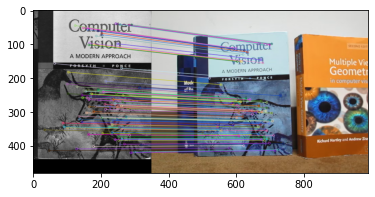

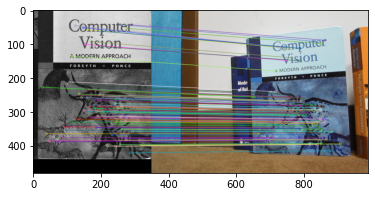

Playing video ....
Press q to exit


In [170]:
# plot matches
im = plt.imshow(animated_video[0])
plt.show()
im = plt.imshow(animated_video[300])
plt.show()
play_video(animated_video)

In [171]:
h_imp = get_homography_implementation(img_pts[0], video_pts[0])
h_built = get_homography_built_in(img_pts[0], video_pts[0])

# compare the two homography matrices
print('Homography matrix from implementation: \n', h_imp)
print('Homography matrix from built in function: \n', h_built)



Homography matrix from implementation: 
 [[ 7.79914515e-01  4.45179742e-03  1.18796228e+02]
 [-4.80529676e-02  7.81762954e-01  7.70371990e+01]
 [-7.94736473e-05 -7.14264626e-05  1.00000000e+00]]
Homography matrix from built in function: 
 [[ 7.81955985e-01  4.97464920e-03  1.18601982e+02]
 [-4.67264870e-02  7.83231074e-01  7.67288486e+01]
 [-7.56232993e-05 -6.98627497e-05  1.00000000e+00]]


In [172]:
# get the corners of the image
w, h = img.shape[:2]
pts = np.float32([[0, 0], [0, w], [h, w], [h, 0]]).reshape(-1, 1, 2)

# get the homography for all the frames
homographies = []
for i in range(len(img_pts)):
    homographies.append(get_homography_implementation(img_pts[i], video_pts[i]))

# get the corners of the image in the video
corners = []
for i in range(len(homographies)):
    corners.append(transformPerspectivePts(pts, homographies[i]))

# draw the corners on the video
video_corners = []
for i in range(len(corners)):
    video_corners.append(main_video[i].copy())
    cv.polylines(video_corners[i], [np.int32(corners[i])], True, (0, 255, 0), 3, cv.LINE_AA)



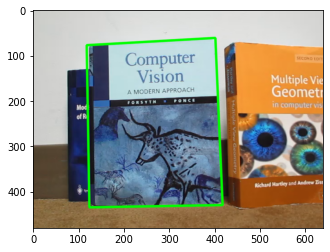

Playing video ....
Press q to exit


In [173]:
# play the video with the corners
plt.imshow(video_corners[0])
plt.show()
play_video(video_corners)

In [180]:
processed_video = video_crop_pad(ar_video, img.shape[:2])

In [181]:
# warp the ar video to the image
warped_frames = []
for i in tqdm(range(len(main_video))):
    warped_frames.append(transformPerspectiveImage(processed_video[i%len(processed_video)], homographies[i], (main_video[i].shape[1], main_video[i].shape[0])))


100%|██████████| 641/641 [05:38<00:00,  1.89it/s]


In [183]:
# overlay the ar video on the main video

overlayed_frames = []
for i in range(len(main_video)):
    # get the perspective transform
    dst = transformPerspectivePts(pts, homographies[i])
    # get the mask
    mask = cv.fillPoly(np.zeros_like(main_video[i]), [np.int32(dst)], (255, 255, 255))
    # get the inverse mask
    inv_mask = cv.bitwise_not(mask)
    # overlay the ar video on the main video
    inv_frame = cv.bitwise_and(main_video[i], inv_mask)
    overlayed_frames.append(cv.bitwise_or(inv_frame, warped_frames[i]))
    


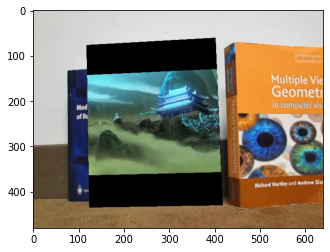

Playing video ....
Press q to exit


In [185]:
plt.imshow(overlayed_frames[0])
plt.show()

play_video(overlayed_frames)